In [111]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [112]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


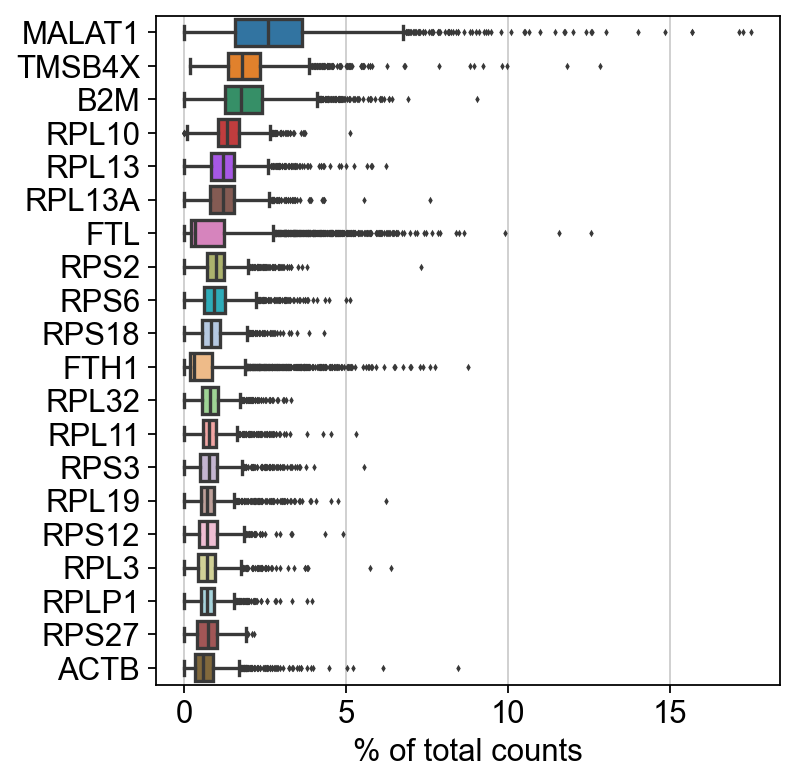

In [90]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [113]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


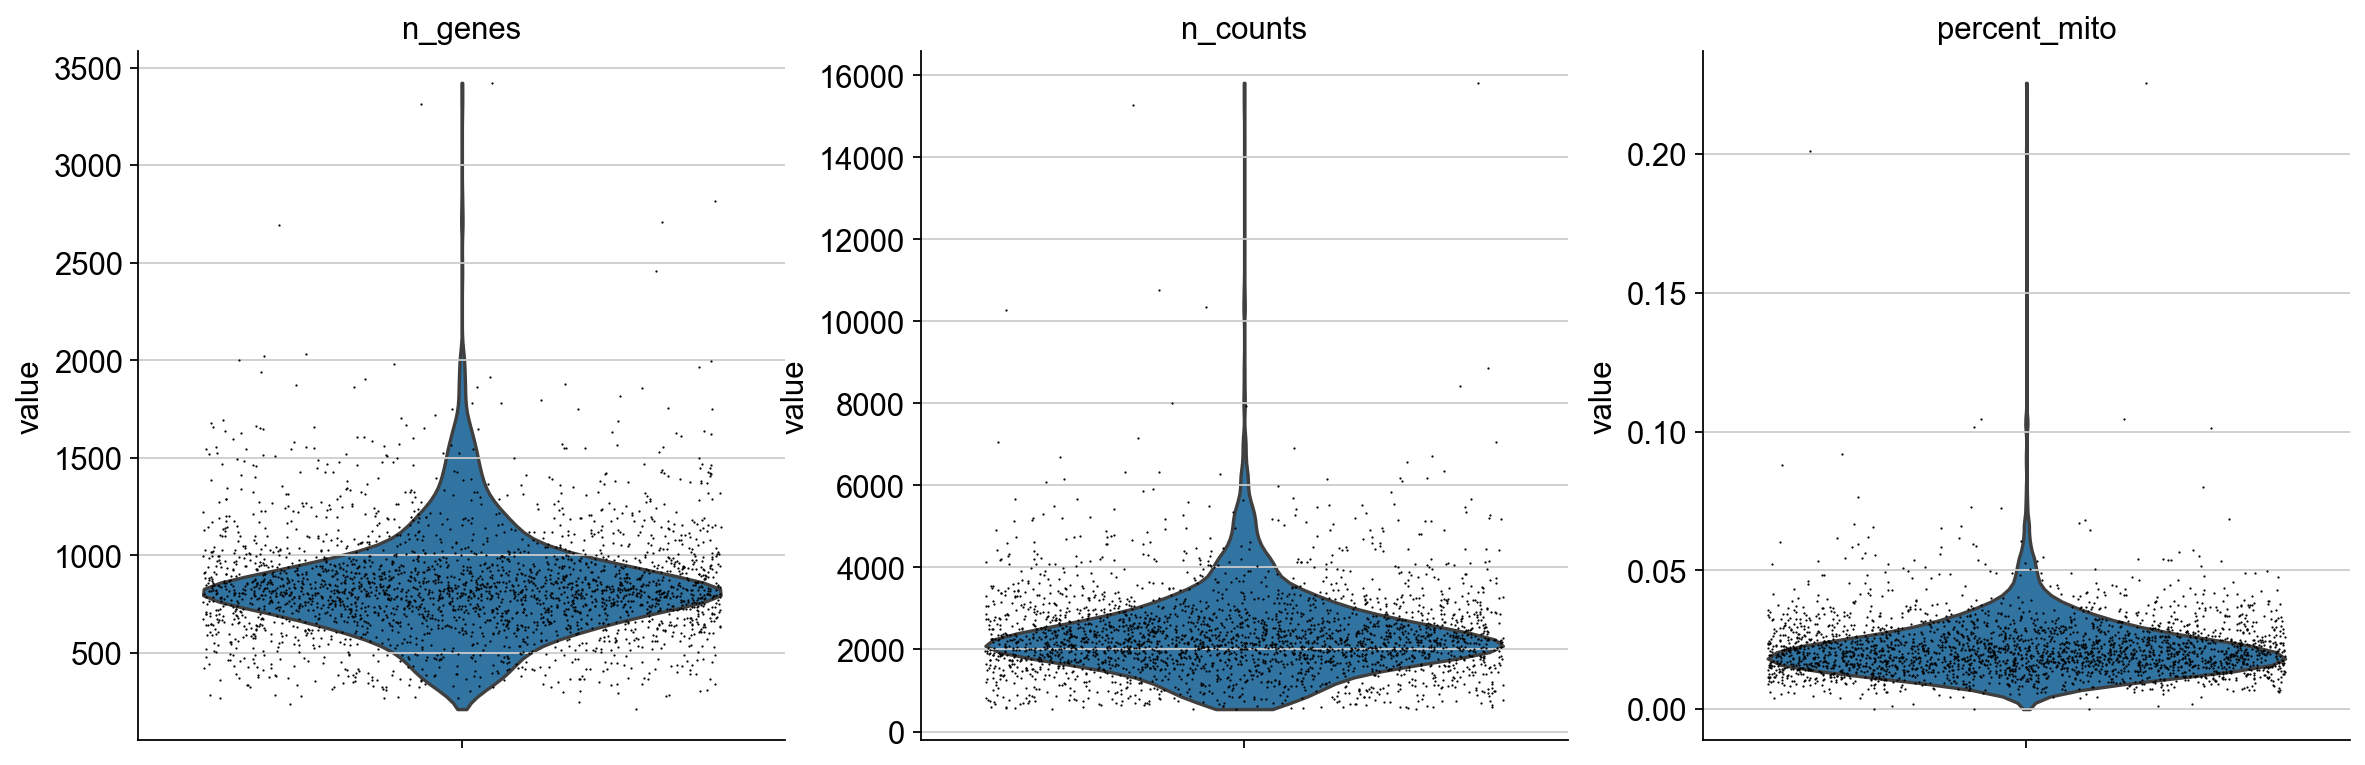

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [114]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [115]:
adata.layers["counts"] = adata.X.copy() # preserve counts
adata.X = adata.layers["counts"].copy() # use counts for normalization and dimensionality reduction
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'counts'

In [94]:
# Store the raw data
adata.raw = adata

In [95]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [96]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'counts'

## Dimension Reduction

### DCA

In [97]:
from dca.api import dca



In [98]:
# Apply DCA
adata = dca(adata, verbose = True)

dca: Successfully preprocessed 2000 genes and 2638 cells.
normalizing by total count per cell


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2023-12-31 02:57:16.771332: W tensorflow/c/c_api.cc:305] Operation '{name:'mean_4/bias/Assign' id:1711 op device:{requested: '', assigned: ''} def:{{{node mean_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mean_4/bias, mean_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-31 02:57:16.906035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-31 02:57:16.906057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device:

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 count (InputLayer)          [(None, 2000)]               0         []                            
                                                                                                  
 enc0 (Dense)                (None, 64)                   128064    ['count[0][0]']               
                                                                                                  
 batch_normalization_12 (Ba  (None, 64)                   192       ['enc0[0][0]']                
 tchNormalization)                                                                                
                                                                                                  
 enc0_act (Activation)       (None, 64)                   0         ['batch_normalization_1

AttributeError: 'RMSprop' object has no attribute 'get_updates'

In [99]:
# Save the data
adata.write('write/pbmc3k_dca.h5ad', compression='gzip')

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


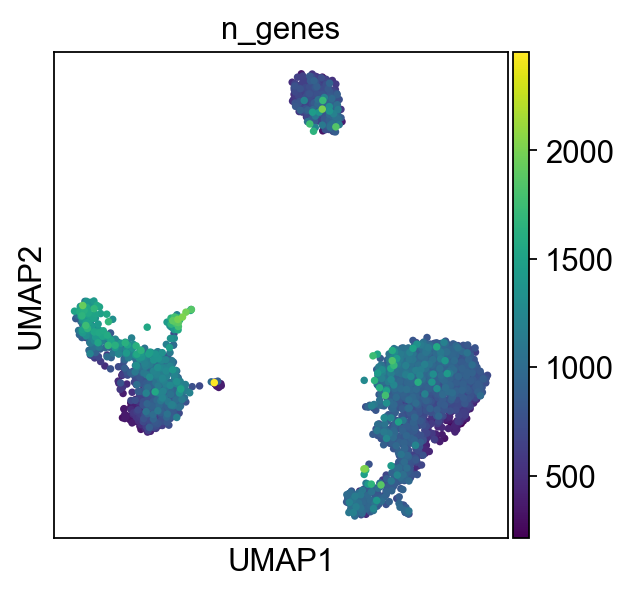

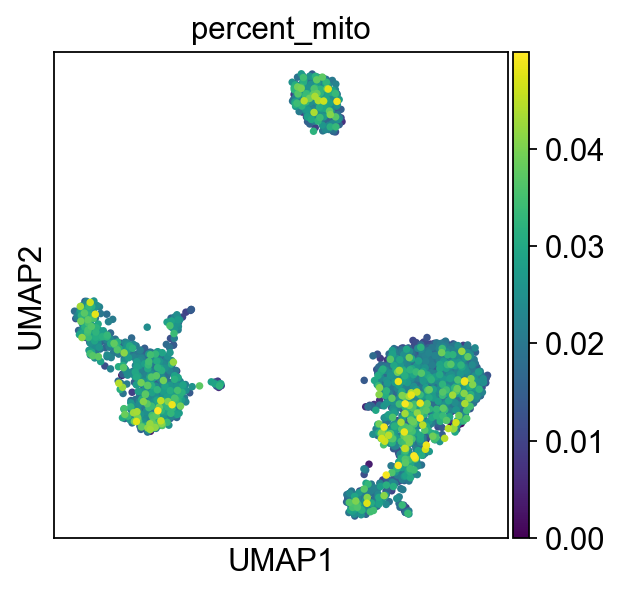

In [110]:
# Plot the results
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.pl.umap(adata, color='n_genes', use_raw=False)



